HR ANALYTICS
===
A company which is active in Big Data and Data Science wants to hire data scientists conduct a training program for aspirants. Many people signed up for their training and the company wants to know which of these candidates really wants to work for them after training or are looking for a new employment because it helps to reduce the cost and time including the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience from candidates are from the signup and enrollment data.

# Libraries

In [1]:
# removes warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# import pandas to be able to use dataframes
import pandas as pd

# customize pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# import plotting library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn

# allow inline plotting on notebook cells
%matplotlib inline

# gives us access to numpy functions
import numpy as np

#from scipy.stats import chisquare

# allows us to implement a train test split strategy
from sklearn.model_selection import train_test_split

# access to the logistic regression class of Sklearn
from sklearn.linear_model import LogisticRegression

# model metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score

# recursive feature elimination, helps in prioritizing features
from sklearn.feature_selection import RFE

# model persistence
from joblib import dump, load

# Exploration

In [2]:
# load training data
training_df = pd.read_csv("data/aug_train.csv")

In [3]:
# let's look at some sample files
training_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


Features
===
* enrollee_id : Unique ID for enrollee
* city: City code
* citydevelopmentindex: Developement index of the city (scaled)
* gender: Gender of enrolee
* relevent_experience: Relevent experience of enrolee
* enrolled_university: Type of University course enrolled if any
* education_level: Education level of enrolee
* major_discipline :Education major discipline of enrolee
* experience: Enrolee total experience in years
* company_size: No of employees in current employer's company
* company_type : Type of current employer
* lastnewjob: Difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – Not looking for job change, 1 – Looking for a job change

In [4]:
# Let's convert enrollee_id and target to text as these are not really numerical in nature

training_df['enrollee_id'] = training_df['enrollee_id'].astype(str) 
training_df['target'] = training_df['target'].astype(str) 

In [5]:
# Let's look at some sample data and see how it aligns to the data dictionary
tmp_df = training_df[training_df['company_type'] =='Funded Startup'].head(1).T
tmp_df.columns = [ 'sample_data']
tmp_df['data_type'] = training_df.dtypes


# The Pandas read_csv command tries to estimate the data type of a feature/column by analyzing the data as it is being read.
# This is then set upon creation of the dataframe. you can check the Pandas documentation if you would like to manually set
# the data type of a column ie. force change a numberal to string
tmp_df

,sample_data,data_type
enrollee_id,666,object
city,city_162,object
city_development_index,0.767,float64
gender,Male,object
relevent_experience,Has relevent experience,object
enrolled_university,no_enrollment,object
education_level,Masters,object
major_discipline,STEM,object
experience,>20,object
company_size,50-99,object


In [6]:
# Let's look at some statistics
training_df.describe(include = 'all')

# describe is a utility function to instantly generate a standardized set of statistics across numerical variables.
# In this case, we forced it to also include text in the form of object type variables which essentially just provides
# information on count and distinct count, most frequent count, and most frequent value. Numerical features get a more
# extensive list of statistics to have a cursory feel of the dataset

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
count,19158,19158,19158.000000,14650,19158,18772,18698,16345,19093,13220,13018,18735,19158.000000,19158
unique,19158,123,NaN,3,2,3,5,6,22,8,6,6,NaN,2
top,8703,city_103,NaN,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,NaN,0.0
freq,1,4355,NaN,13221,13792,13817,11598,14492,3286,3083,9817,8040,NaN,14381
mean,NaN,NaN,0.828848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.366896,NaN
std,NaN,NaN,0.123362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.058462,NaN
min,NaN,NaN,0.448000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
25%,NaN,NaN,0.740000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,NaN
50%,NaN,NaN,0.903000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.000000,NaN
75%,NaN,NaN,0.920000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.000000,NaN


In [7]:
# there are 10 objects (strings/categorical) and 4 numerical features
training_df.dtypes.value_counts()

object     12
int64       1
float64     1
dtype: int64

In [8]:
# you can filter to specific features / columns if needed
training_df[['gender','relevent_experience']].describe(include = 'all')

,gender,relevent_experience
count,14650,19158
unique,3,2
top,Male,Has relevent experience
freq,13221,13792


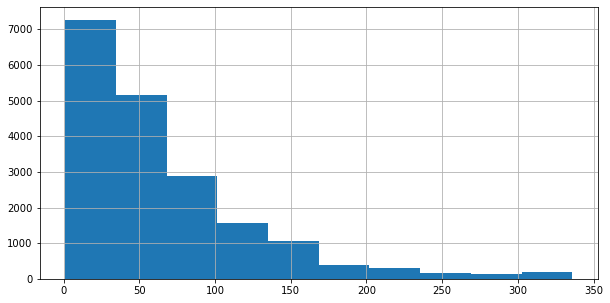

In [9]:
# Let's generate a histogram

#figsize=(10,5) specifies the size of the chart
training_df['training_hours'].hist(figsize=(10,5))

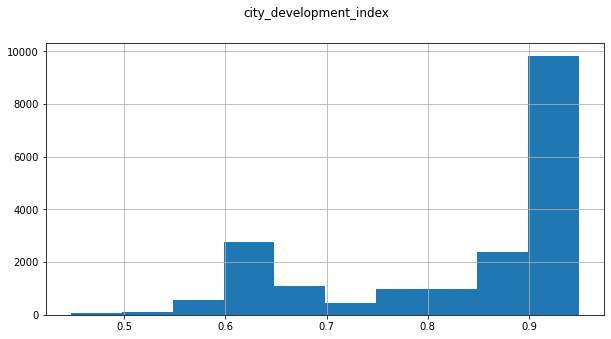

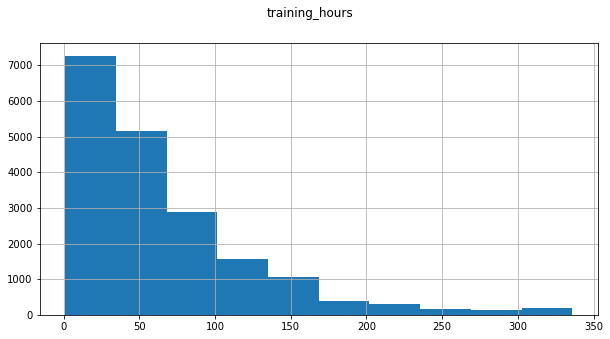

In [10]:
# let's look at all the numerical features
for column_name, item in training_df.iteritems():
    
    if(item.dtype != 'object'):
        item.hist(figsize=(10,5))
        
        # these are functions that call on the matplotlib library plot utility functions to 
        # 1) assign a chart title and 2) "write" the plot to the notebook
        plt.suptitle(column_name)
        plt.show()  
  

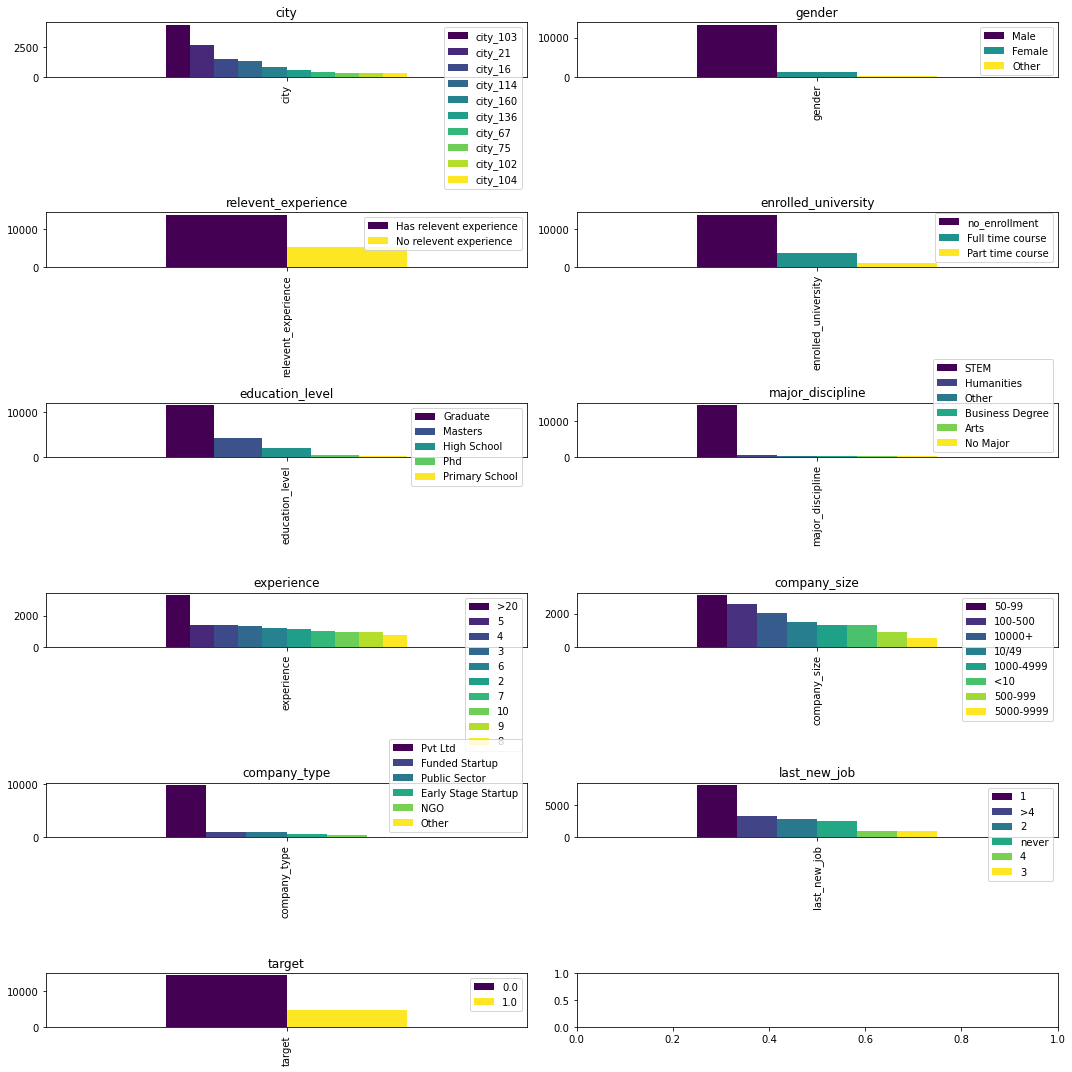

In [11]:
# let's create simple code that will loop thru all categorical values and plot their distribution 
# to manage the chart size, we'll only plot the top 10 unique values in terms of counts

f, axs = plt.subplots(6,2, figsize=(15,15))
axs = axs.ravel()
j = 0

for i in training_df.columns:
    series = training_df[i]
    tmp_df = pd.DataFrame(series.value_counts())
    tmp_df = tmp_df.head(10).T

    # let's only plot those non-numerical data types as well as filter out enrollee id because that wouldn't make sense
    if(series.dtype == 'object' and i != 'enrollee_id'):
        tmp_df.plot.bar(ax=axs[j],title=i,cmap="viridis")
        j+=1
plt.tight_layout()
plt.show()

# Target

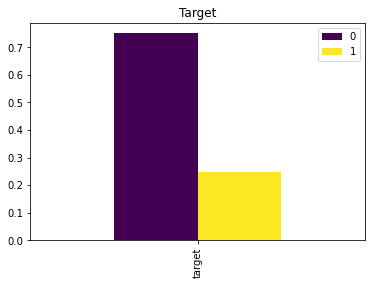

In [12]:
# Let's look at the target variable and how the attributes are distributed with respect to it
# Here's an alternative look at the plot where in we set normalize = True to show values in percentages

tmp_df = pd.DataFrame(training_df['target'].value_counts(normalize=True).reset_index(drop=True)).T
tmp_df.plot.bar(title="Target",cmap="viridis")

# Please note that value_counts() excludes NA values, so numbers might not add up to 1. Pls refer to pandas Documentation

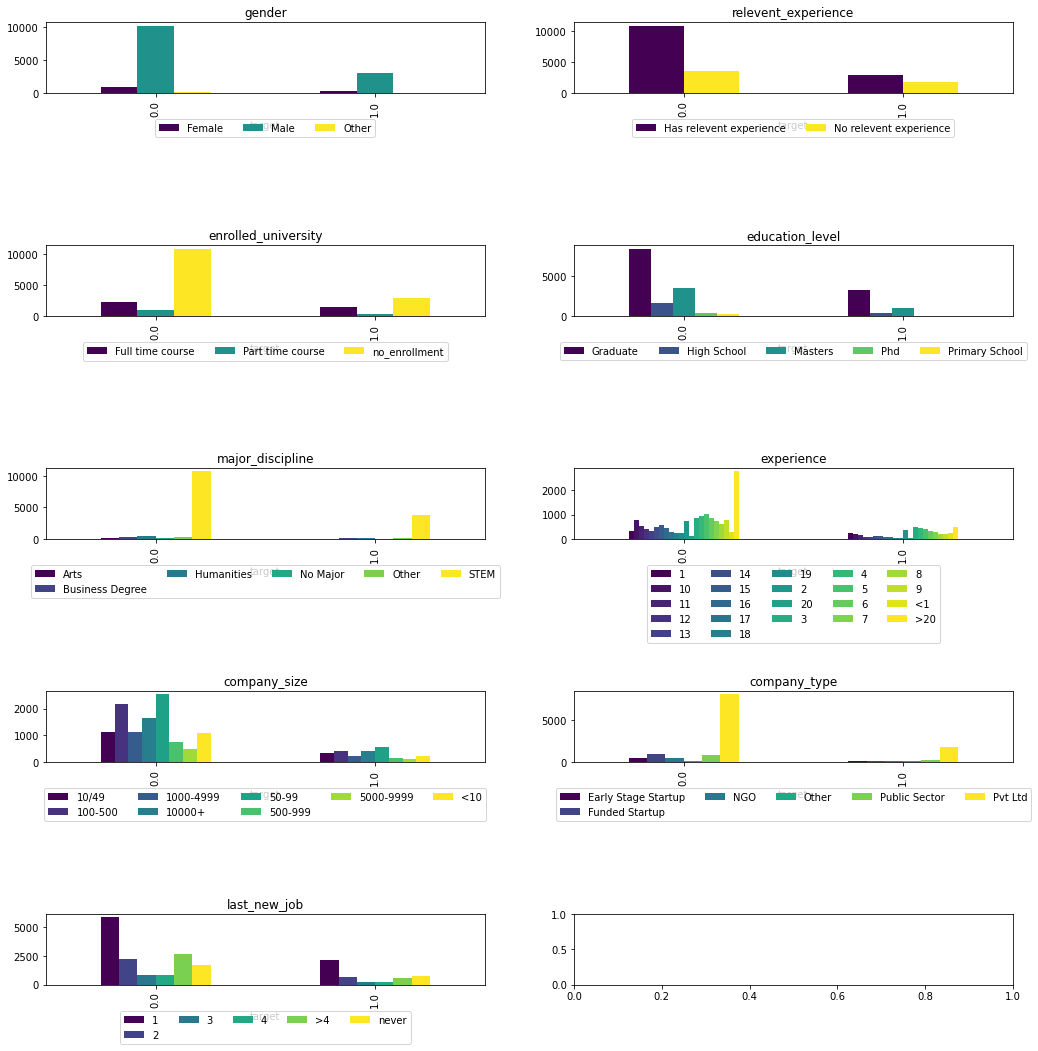

In [13]:
# let's create simple code that will loop thru all categorical values and plot their distribution 
# to manage the chart size, we'll only plot the top 10 unique values in terms of counts

f, axs = plt.subplots(5,2, figsize=(15,15))
axs = axs.ravel()
j = 0
ignore_list = ['target','enrollee_id','city','city_development_index']

for i in training_df.columns:
    series = training_df[i]
    tmp_df = pd.DataFrame(series.value_counts())
    tmp_df = tmp_df.head(10).T

    # let's only plot those non-numerical data types as well as filter out enrollee id because that wouldn't make sense
    if(series.dtype == 'object' and i not in ignore_list):
        tmp_df = pd.pivot_table(training_df,index="target",values="enrollee_id",columns=i,aggfunc="count")
        tmp_df.plot.bar(ax=axs[j],title=i,cmap="viridis")
        axs[j].legend(loc='upper center', bbox_to_anchor=(0.5, -0.30), ncol=5)
        j+=1
plt.tight_layout()
plt.show()

##WHAT IF WE WANT TO PLOT PERCENTAGES INSTEAD OF COUNT

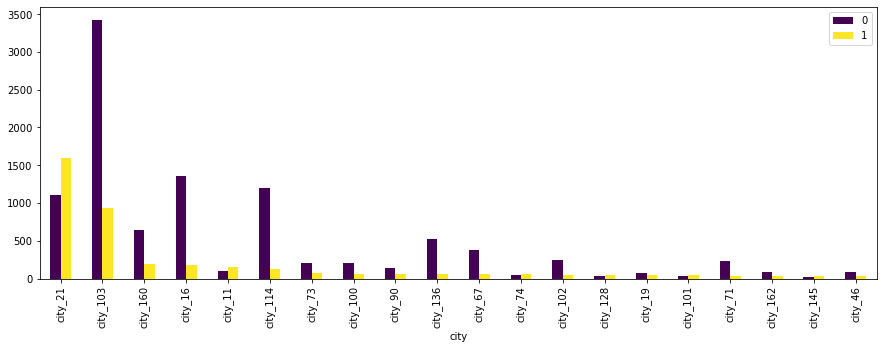

In [14]:
# since city has a larger list, let's look at it separately - let's only look at the top 20
# first one is sorted highest to lowest counts based on target == 1 

tmp_df = pd.pivot_table(training_df[['target','enrollee_id','city']],index="city",columns="target",aggfunc="count")
tmp_df.columns = [0,1]
tmp_df.columns.index = 'city'
tmp_df = tmp_df.sort_values(1,ascending=False)
tmp_df[0:20].plot.bar(cmap="viridis",figsize=(15,5))

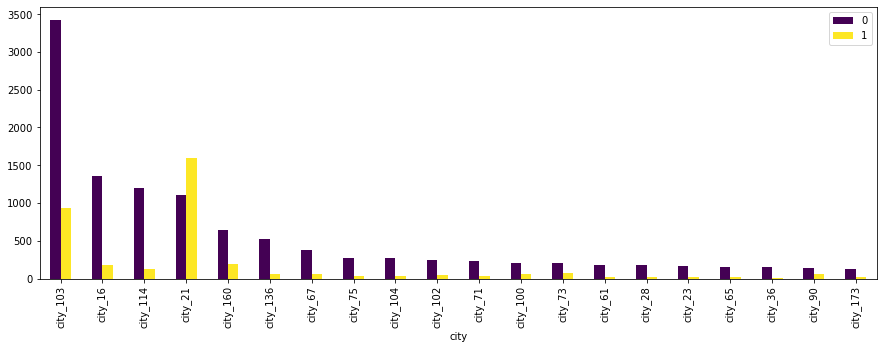

In [15]:
# second is sorted highest to lowest counts based on target == 0 

tmp_df = pd.pivot_table(training_df[['target','enrollee_id','city']],index="city",columns="target",aggfunc="count")
tmp_df.columns = [0,1]
tmp_df.columns.index = 'city'
tmp_df = tmp_df.sort_values(0,ascending=False)
tmp_df[0:20].plot.bar(cmap="viridis",figsize=(15,5))

City development index
===
The City Development Index was developed for the Second United Nations Conference on Human Settlements (Habitat II) in 1996 and measures the level of development in cities. The Urban Indicators Programme of the United Nations Human Settlements Programme (UN-Habitat) developed the indicator so that they could rank cities of the world according to their level of development and as a display of indicators depicting development. The CDI cuts across the different clusters identified in the Urban Indicator Framework as it is based on five sub indices namely, infrastructure, waste, health, education and city product. It is useful as it provides a snap-shot view of how cities are doing with respect to the different indices. It was invented by Dr Joe Flood, first Coordinator of the Urban Indicators Program, following a statistical analysis of city indicators data.
Reference :https://en.wikipedia.org/wiki/City_development_index

![Computation](img/Calculation-of-CDI-by-UN-HABITAT-GUIP-Index-Formula.png)

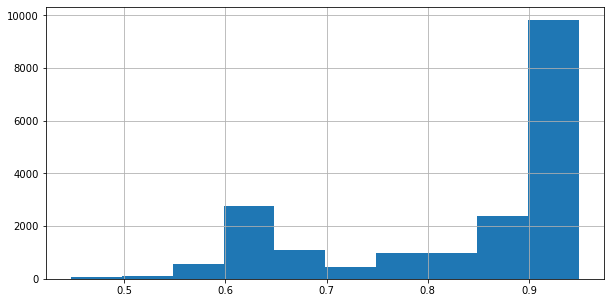

In [16]:
training_df['city_development_index'].hist(figsize=(10,5))

In [17]:
training_df[['city_development_index','city']].drop_duplicates().sort_values('city_development_index',ascending=False)[0:20]

,city_development_index,city
112,0.949,city_98
61,0.939,city_75
183,0.939,city_28
15,0.926,city_114
157,0.925,city_89
115,0.925,city_97
41,0.924,city_104
49,0.923,city_83
903,0.921,city_167
6,0.920,city_160


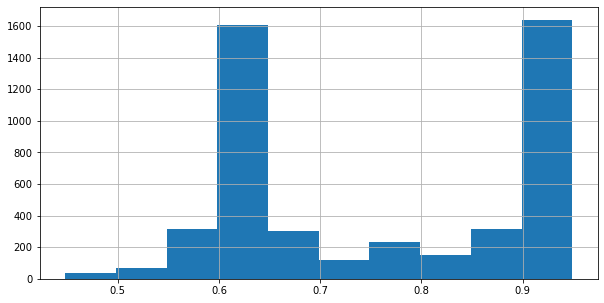

In [18]:
tmp_df = training_df[training_df['target']=='1.0']
tmp_df['city_development_index'].hist(figsize=(10,5))

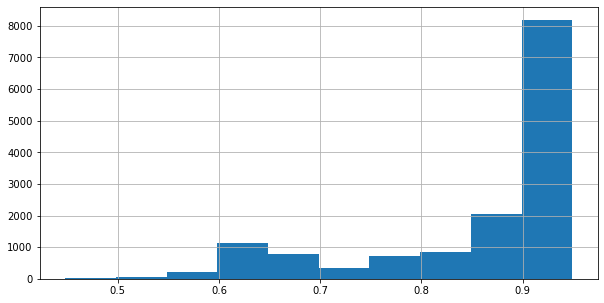

In [19]:
tmp_df = training_df[training_df['target']=="0.0"]
tmp_df['city_development_index'].hist(figsize=(10,5))

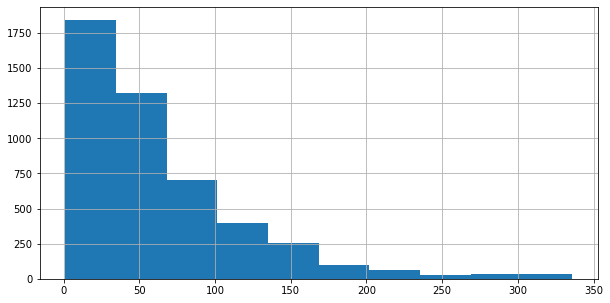

In [20]:
tmp_df = training_df[training_df['target']=='1.0']
tmp_df['training_hours'].hist(figsize=(10,5))

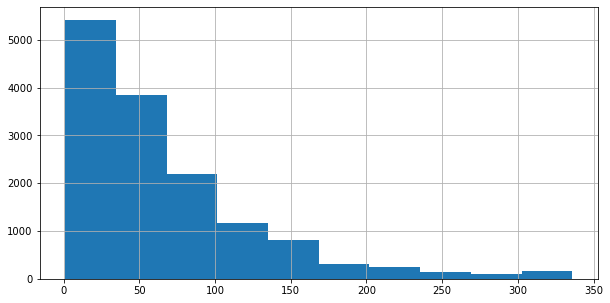

In [21]:
tmp_df = training_df[training_df['target']=='0.0']
tmp_df['training_hours'].hist(figsize=(10,5))

# Correlation

We need to find a good idea of what feature to prioritize on our initial base model before we do any sort of optimization. Let's do some basic correlation tests 

In [22]:
# Numerical Correlation using Pearson

corrMatrix=training_df[["city","city_development_index","gender","relevent_experience","enrolled_university","education_level",
                   "major_discipline","experience","company_size","company_type","last_new_job","training_hours","target"]].corr()

# notice that the function automatically remove 'objects' and only computes for numerical features
corrMatrix

,city_development_index,training_hours
city_development_index,1.00000,0.00192
training_hours,0.00192,1.00000


In [23]:
# let's review the data types
training_df.dtypes

enrollee_id                object
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                     object
dtype: object

# Preprocessing

In [24]:
# How many null values do we have per column?

# Let's create a new dataframe
tmp_df = pd.DataFrame()

# add new columns
tmp_df['data_type'] = training_df.dtypes
tmp_df['non_null_count'] = training_df.describe(include='all').T['count']
tmp_df['null_count'] = training_df.isnull().sum()
tmp_df['total'] = training_df.shape[0]
tmp_df['null_count/total'] = (tmp_df['null_count'] / training_df.shape[0]) * 100
tmp_df

,data_type,non_null_count,null_count,total,null_count/total
enrollee_id,object,19158,0,19158,0.000000
city,object,19158,0,19158,0.000000
city_development_index,float64,19158,0,19158,0.000000
gender,object,14650,4508,19158,23.530640
relevent_experience,object,19158,0,19158,0.000000
enrolled_university,object,18772,386,19158,2.014824
education_level,object,18698,460,19158,2.401086
major_discipline,object,16345,2813,19158,14.683161
experience,object,19093,65,19158,0.339284
company_size,object,13220,5938,19158,30.994885


# Preprocessing design and assumptions

* Some columns we can drop because they either have duplicates ie. city = city index
* Some columns maybe have too many "categories" so we would need to group them to minimize complexity ie. experience/ city index
* Numerical features use ZERO for null by default - no action needed
* Education_level  has less than 10% null counts - we will drop the records with null
* Gender, major_discipline, company_size, company_type have high null counts (>10%) - we need to think of a strategy on dealing with this. either we:
    1. drop all rows with null value 
    2. drop the column itself 
    3. impute with a different value
    4. we can also create an entirely new variable and interpret the original variable differently based on our model's goal

* Experience, last_new_job, enrolled_university  - we will use 3. and impute to the "lowest" category ie. experience means no experience
* Gender, major_discipline, company_type, company size - we will remove this to remove bias to gendar (and similar) and replace it with an indicator of availability of information. Gender_ind = 1 means it is non null. It tells us that participant was willing to provide data


In [25]:
# we are going to use a lambda function. A lambda function is a temporary anonmyous function they gets applied to
# to all rows of the feature/ column

# if a variable compared to itself is not equal, then its a null value
# return 0 if the value is false (null) else return 1 to indicate a gender value exists
training_df['gender_ind'] = training_df['gender'].apply(lambda x: 0 if(x!=x) else 1)
training_df['major_discipline_ind'] = training_df['major_discipline'].apply(lambda x: 0 if(x!=x) else 1)
training_df['company_type_ind'] = training_df['company_type'].apply(lambda x: 0 if(x!=x) else 1)
training_df['company_size_ind'] = training_df['company_size'].apply(lambda x: 0 if(x!=x) else 1)

## WHAT IF WE WANT TO STANDARDIZE SKWED VARIABLES IE TRAINING_HRS?

In [26]:
# drop values with null for Education_level
training_df = training_df[training_df['education_level'].notna()]


In [27]:
training_df['last_new_job'].value_counts()

1        7914
>4       3238
2        2860
never    2274
4        1020
3        1006
Name: last_new_job, dtype: int64

In [28]:
# impute Experience, last_new_job, enrolled_university to the "lowest" value

# last new job.
# replace null with never
training_df['last_new_job_fixed'] = training_df['last_new_job'].replace(np.nan,'never')

# Experience
# replace null with 0
training_df['experience_fixed'] = training_df['experience'].replace(np.nan,'0')


# enrolled_university
# replace null with no_enrollment
training_df['enrolled_university_fixed'] = training_df['enrolled_university'].replace(np.nan,'no_enrollment')


In [29]:
# let's create a numerical version of experience

# this is how you declare a function
def change_value(x):
    if(x!=x):
        return 0  
    if(x=='>20'):
        return 21
    elif(x=='<1'):
        return 0
    else:
        return int(x)

# you can pass functions in an apply method
training_df['experience_num'] = training_df['experience_fixed'].apply(lambda x: change_value(x))
training_df['experience_num'].value_counts()

21    3230
5     1387
4     1369
3     1306
6     1190
2     1063
7     1008
10     970
9      966
8      790
15     675
11     657
14     581
0      550
1      516
16     499
12     487
13     397
17     336
19     301
18     277
20     143
Name: experience_num, dtype: int64

In [30]:
# regroup experience and city index

# experience. we will use the following categories
# level 0 (0-1), level 1 (2-5), level 2(6-10), level 3 (11-15), level 4 (16-19), level_5(20>)
cut_labels = ['level_0','level_1','level_2','level_3','level_4','level_5']
cut_bins = [-1,2,5,10,16,20,21]
training_df['xp_cat'] = pd.cut(training_df['experience_num'], bins=cut_bins,labels=cut_labels)

# city_development_index

cut_labels = ['city_index_1','city_index_2','city_index_3','city_index_4','city_index_5']

#divide equality into 5 cuts
training_df['ct_idx_cat'] = pd.cut(training_df['city_development_index'], bins=5,labels=cut_labels)

training_df[['experience_num','xp_cat','city_development_index','ct_idx_cat']].head()

,experience_num,xp_cat,city_development_index,ct_idx_cat
0,21,level_5,0.920,city_index_5
1,15,level_3,0.776,city_index_4
2,5,level_1,0.624,city_index_2
3,0,level_0,0.789,city_index_4
4,21,level_5,0.767,city_index_4


In [31]:
# remove unnneeded columns
del training_df['city']

del training_df['last_new_job']
del training_df['experience']
del training_df['enrolled_university']
del training_df['city_development_index']
del training_df['experience_num']
del training_df['experience_fixed']

del training_df['gender']
del training_df['major_discipline']
del training_df['company_type']
del training_df['company_size']



In [32]:
# after our transformations, what does our dataset look like?
training_df.head()

,enrollee_id,relevent_experience,education_level,training_hours,target,gender_ind,major_discipline_ind,company_type_ind,company_size_ind,last_new_job_fixed,enrolled_university_fixed,xp_cat,ct_idx_cat
0,8949,Has relevent experience,Graduate,36,1.0,1,1,0,0,1,no_enrollment,level_5,city_index_5
1,29725,No relevent experience,Graduate,47,0.0,1,1,1,1,>4,no_enrollment,level_3,city_index_4
2,11561,No relevent experience,Graduate,83,0.0,0,1,0,0,never,Full time course,level_1,city_index_2
3,33241,No relevent experience,Graduate,52,1.0,0,1,1,0,never,no_enrollment,level_0,city_index_4
4,666,Has relevent experience,Masters,8,0.0,1,1,1,1,4,no_enrollment,level_5,city_index_4


In [33]:
# do we still have any null values?
training_df.isnull().sum()

enrollee_id                  0
relevent_experience          0
education_level              0
training_hours               0
target                       0
gender_ind                   0
major_discipline_ind         0
company_type_ind             0
company_size_ind             0
last_new_job_fixed           0
enrolled_university_fixed    0
xp_cat                       0
ct_idx_cat                   0
dtype: int64

In [34]:
# let's make sure our data types are consistent across

training_df = training_df.astype(object)
training_df['training_hours'] = training_df['training_hours'].astype(int)
training_df.dtypes

enrollee_id                  object
relevent_experience          object
education_level              object
training_hours                int32
target                       object
gender_ind                   object
major_discipline_ind         object
company_type_ind             object
company_size_ind             object
last_new_job_fixed           object
enrolled_university_fixed    object
xp_cat                       object
ct_idx_cat                   object
dtype: object

In [35]:
# let's use comprehension to generate a list of variables that have categorical information
remove_list = ['enrollee_id','target'] #these guys aren't really categorical or part of the feature set

cat_var_list = [x for ind, x in enumerate(training_df.columns) if(training_df.dtypes[ind]!='int64' and x not in remove_list)]
cat_var_list = [x for ind, x in enumerate(training_df.columns) if(training_df.dtypes[ind]!='int32' and x not in remove_list)]
num_var_list = [x for ind, x in enumerate(training_df.columns) if(training_df.dtypes[ind]=='int64' or training_df.dtypes[ind]=='int32')]

# we separate our feature list into two, so we can safely process our categorical features and generate dummy indicators

In [36]:
# convert to dummy variables
cat_processed_training_df = pd.get_dummies(training_df[cat_var_list],cat_var_list)
# this takes a categorical variable, converts each value into a column, and assigns a 1 or 0 as indicator of that value

# for consistency, lets place our numerical features here
num_processed_training_df = training_df[num_var_list]

# let's finalize the training data set by combining the two groups into one dataframe
final_training_df = pd.concat([cat_processed_training_df,num_processed_training_df,training_df['target']],axis=1)
final_training_df.head()

# let's look at our finalized analytical base table

,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,education_level_Graduate,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,gender_ind_0,gender_ind_1,major_discipline_ind_0,major_discipline_ind_1,company_type_ind_0,company_type_ind_1,company_size_ind_0,company_size_ind_1,last_new_job_fixed_1,last_new_job_fixed_2,last_new_job_fixed_3,last_new_job_fixed_4,last_new_job_fixed_>4,last_new_job_fixed_never,enrolled_university_fixed_Full time course,enrolled_university_fixed_Part time course,enrolled_university_fixed_no_enrollment,xp_cat_level_0,xp_cat_level_1,xp_cat_level_2,xp_cat_level_3,xp_cat_level_4,xp_cat_level_5,ct_idx_cat_city_index_1,ct_idx_cat_city_index_2,ct_idx_cat_city_index_3,ct_idx_cat_city_index_4,ct_idx_cat_city_index_5,training_hours,target
0,1,0,1,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,36,1.0
1,0,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,47,0.0
2,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,83,0.0
3,0,1,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,52,1.0
4,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,8,0.0


In [37]:
final_training_df.shape # rows, columns

(18698, 37)

# Train and Test Split

In [38]:
# setup train and test split strategy
X = final_training_df.loc[:, final_training_df.columns != 'target']
y = final_training_df['target'].astype(float) # convert to float

# here we do a few things: 1) separate our data set into 30% and 70% splits
# 70% will be used for as training data set
# 30% will be used to test the resulting model
# X represents our features
# y reprsents our target variable (1 is most likely to apply to the company after the training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = final_training_df.loc[:, final_training_df.columns != 'target'].columns 
# we keep the column names to be used later

# Logistic Regression (Base model)

In [39]:
# Base model using all variables
logreg = LogisticRegression(random_state=0)

# Let's input our training data set and fit our model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [40]:
# predict against X_test
y_pred = logreg.predict(X_test)
y_pred

array([0., 1., 0., ..., 1., 0., 0.])

# Model Metrics

Let's look at some metrics to see how our classifier performed

![Confusion Matrix](https://www.svds.com/wp-content/uploads/2015/08/matrix.png "Confusion Matrix")

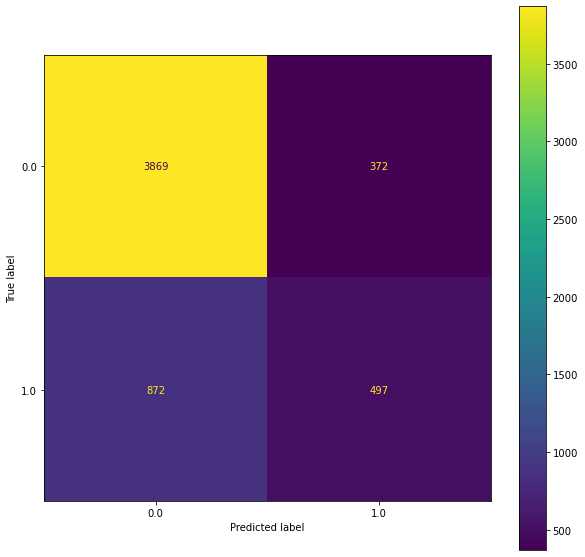

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(logreg, X_test, y_test, ax=ax)  
plt.show()  

![Key Metrics](https://miro.medium.com/max/1872/1*pOtBHai4jFd-ujaNXPilRg.png "Key Metrics")

In [42]:
# How much are classified in the positive class that are ACTUALLY positive?
# Returns mostly positive instances.
precision_score(y_test,y_pred)

0.571921749136939

In [43]:
# How much of the  positives did we correctly classify as positive?
# Finds as many positive instances as possible.
recall_score(y_test,y_pred)

0.36303871439006574

In [44]:
# How much of the total did we predict correctly?
# The closer to 1 the better (meaning 100% accurate)
accuracy_score( y_test,y_pred)

0.77825311942959

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds.

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).

![ROC AUC](https://glassboxmedicine.files.wordpress.com/2019/02/roc-curve-v2.png?w=576 "ROC AUC")


ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s.


![TPR FPR](https://miro.medium.com/max/500/1*7_2ai1_ICde2nq83ksvZIg.png "TPR FPR")

To generate the ROC Curve we compute the TPR and FPR for using our model and a random classifier (no skill) and plot the resulting values

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.782


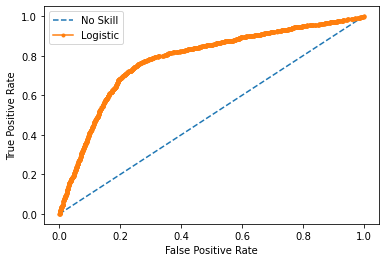

In [45]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = logreg.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Logistic Regression (Optimized using RFE)

RFE works by recursively removing attributes and building a model on attributes that remain. It uses model accuracy (by default) to identify which attributes (and combinations of attributes) contribute the most to predicting the target attribute.


![RFE](https://miro.medium.com/max/1078/1*GtT1JXyPL7LNHa9EVrtcfg.png "RFE")

In [46]:
# Recursive Feature Elimination - iterate thru features and 
# Using RFE to prioritize variables based on feature importance (default uses coef_ or feature_importances_)

#identify top x most significant features (default uses half)
rfe_logreg = LogisticRegression(random_state=0)
rfe = RFE(rfe_logreg) # if no value is passed for no. of features to identify, it will default to half of total features
rfe = rfe.fit(X_train, y_train)


In [47]:
# Let's make the results more human readable
rfe_df = pd.DataFrame([columns,rfe.support_,rfe.ranking_]).T
rfe_df.columns = ['name','support','rank']
rfe_df

# rank 1 or true means that the RFE method recommends these features to be used as it helps to increase accuracy metric
# given the restriction on no. of features (half of total features by default)

,name,support,rank
0,relevent_experience_Has relevent experience,False,4
1,relevent_experience_No relevent experience,True,1
2,education_level_Graduate,True,1
3,education_level_High School,False,15
4,education_level_Masters,False,2
5,education_level_Phd,False,17
6,education_level_Primary School,True,1
7,gender_ind_0,False,16
8,gender_ind_1,False,9
9,major_discipline_ind_0,True,1


In [48]:
# List of recommended variables
rfe_df[rfe_df['support']==True]

,name,support,rank
1,relevent_experience_No relevent experience,True,1
2,education_level_Graduate,True,1
6,education_level_Primary School,True,1
9,major_discipline_ind_0,True,1
10,major_discipline_ind_1,True,1
11,company_type_ind_0,True,1
12,company_type_ind_1,True,1
13,company_size_ind_0,True,1
14,company_size_ind_1,True,1
20,last_new_job_fixed_never,True,1


In [49]:
# what factors are more likely to support a student to actually apply to the company and change jobs?

In [50]:
rfe_df[rfe_df['support']==True].shape  # We'll only use the top 18 features (half of total)

(18, 3)

# Remodel using prioritized features

In [51]:
# Let's filter our train data set to the prioritized features
prioritized_features = rfe_df[rfe_df['support']==True]['name'].values
prioritized_X_train = X_train[prioritized_features]

In [52]:
# Use the new training data set to train/fit our new model
logreg2 = LogisticRegression(random_state=0,solver='liblinear',max_iter=100)
logreg2.fit(prioritized_X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [53]:
# predict against X test
prioritized_y_pred = logreg2.predict(X_test[prioritized_features])
prioritized_y_pred

array([0., 1., 0., ..., 1., 0., 0.])

# Model Metrics

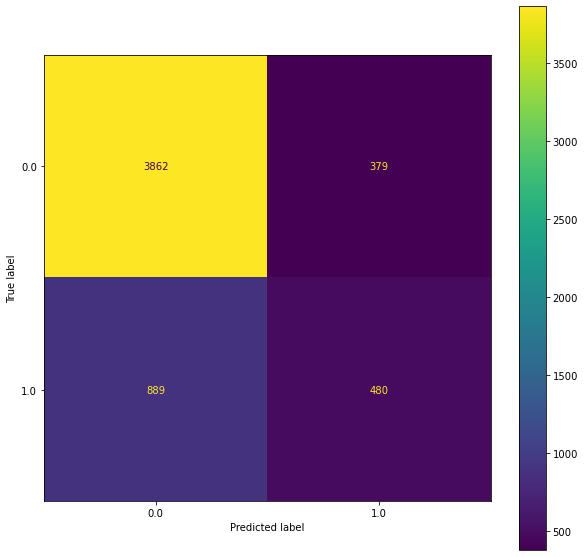

In [54]:
# confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(logreg2, X_test[prioritized_features], y_test, ax=ax)  
plt.show()

# the numbers represent amount of records per classification

In [55]:
precision_score(y_test,prioritized_y_pred) 

0.5587892898719441

In [56]:
recall_score(y_test,prioritized_y_pred) 

0.3506208911614317

In [57]:
accuracy_score(y_test,prioritized_y_pred) 

0.7739750445632798

No Skill: ROC AUC=0.50000
Logistic: ROC AUC=0.78230


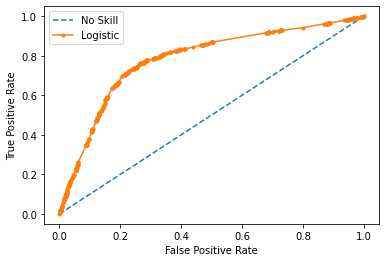

In [58]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = logreg2.predict_proba(X_test[prioritized_features])
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
prioritized_lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.5f' % (ns_auc))
print('Logistic: ROC AUC=%.5f' % (prioritized_lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# What about feature significant?

Here are a few examples on how to approach this.

## Using statsmodels

In [59]:
# compare with statsmodels
import statsmodels.api as sm

# we create a logistic regression model via statsmodels library and generate summary statistics
sm_model = sm.Logit(y_train, sm.add_constant(prioritized_X_train)).fit(disp=0)
print(sm_model.pvalues)
sm_model.summary()

const                                         9.999997e-01
relevent_experience_No relevent experience    2.272482e-07
education_level_Graduate                      2.053333e-05
education_level_Primary School                9.874673e-02
major_discipline_ind_0                        9.999996e-01
major_discipline_ind_1                        9.999998e-01
company_type_ind_0                                     NaN
company_type_ind_1                                     NaN
company_size_ind_0                            9.999998e-01
company_size_ind_1                            9.999997e-01
last_new_job_fixed_never                      4.942328e-13
enrolled_university_fixed_no_enrollment       1.535385e-03
xp_cat_level_0                                1.496171e-03
xp_cat_level_5                                1.267435e-03
ct_idx_cat_city_index_1                                NaN
ct_idx_cat_city_index_2                                NaN
ct_idx_cat_city_index_3                                N

e:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                13088
Model:                          Logit   Df Residuals:                    13073
Method:                           MLE   Df Model:                           14
Date:                Fri, 25 Feb 2022   Pseudo R-squ.:                  0.1921
Time:                        22:13:51   Log-Likelihood:                -5974.6
converged:                      False   LL-Null:                       -7394.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         -0.3357   8.91e+05  -3.77e-07      1.000   -1.75e+06    1.75e+06
relevent_experience_No relevent experience     0.3092      0.060      5.176      0.000       0.192       0.426
education_level_Graduate                       0.2359      0.055      4.259      0.000       0.127       0.344
education_level_Primary School                -0.3855      0.234     -1.651      0.099      -0.843       0.072
major_discipline_ind_0                        -0.6331   1.18e+06  -5.35e-07      1.000   -2.32e+06    2.32e+06
major_discipline_ind_1                         0.2974   1.18e+06   2.52e-07      1.000   -2.32e+06    2.32e+06
company_type_ind_0                            -0.0032        nan        nan        nan         nan         nan
company_type_ind_1                            -0.3325        nan        nan        nan         nan         nan
company_size_ind_0                             0.4177    1.9e+06   2.19e-07      1.000   -3.73e+06    3.73e+06
company_size_ind_1                            -0.7534   1.92e+06  -3.92e-07      1.000   -3.76e+06    3.76e+06
last_new_job_fixed_never                      -0.5226      0.072     -7.227      0.000      -0.664      -0.381
enrolled_university_fixed_no_enrollment       -0.1750      0.055     -3.168      0.002      -0.283      -0.067
xp_cat_level_0                                 0.2227      0.070      3.175      0.001       0.085       0.360
xp_cat_level_5                                -0.2311      0.072     -3.223      0.001      -0.372      -0.091
ct_idx_cat_city_index_1                        0.8687        nan        nan        nan         nan         nan
ct_idx_cat_city_index_2                        1.1174        nan        nan        nan         nan         nan
ct_idx_cat_city_index_3                       -0.4746        nan        nan        nan         nan         nan
ct_idx_cat_city_index_4                       -0.8524        nan        nan        nan         nan         nan
ct_idx_cat_city_index_5                       -0.9948        nan        nan        nan         nan         nan
==============================================================================================================
"""

Since we have a classic logistic linear regression model in our hands, we can use statsmodel library to generate metrics to identify feature significance. Here you can see P values for each feature when used in the model. Those that have lower than 0.05 indicate significance.

You can refer to this [link](https://www.pluralsight.com/guides/interpreting-data-using-statistical-models-python) for more information.

## Using shapley values

For non-classical models where the approach is essentially a black box, we look at using shap library as an alternative for interpretation.

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations.

For reference on how this can be used for logistic regression, look [here](https://shap-lrjball.readthedocs.io/en/latest/examples.html#linear-explainer).



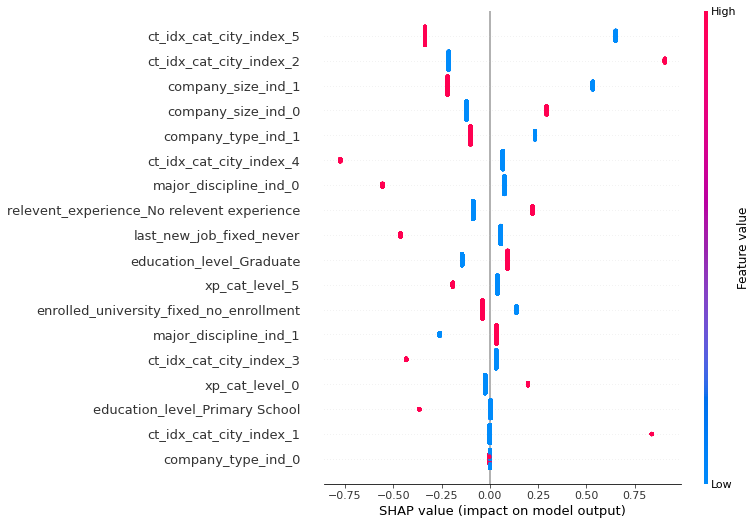

In [60]:
import shap
shap.initjs()

# use LinearExplainer SHAP to explain test set predictions
explainer = shap.LinearExplainer(logreg2, prioritized_X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test[prioritized_features])
X_test_array = X_test[prioritized_features]

# plot the SHAP values for the  output 
shap.summary_plot(shap_values, X_test_array, feature_names=prioritized_features)

# Is our model much better off now compared than before? why? why not?

In [61]:
base = {"precision":precision_score(y_test,y_pred),"recall":recall_score(y_test,y_pred),"accuracy":accuracy_score(y_test,y_pred),"roc auc":lr_auc}
prio = {"precision":precision_score(y_test,prioritized_y_pred),"recall":recall_score(y_test,prioritized_y_pred),"accuracy":accuracy_score(y_test,prioritized_y_pred),"roc auc":prioritized_lr_auc}

tmp_df = pd.DataFrame([base,prio])
tmp_df = tmp_df.T
tmp_df.columns = ['base','prioritized']
tmp_df

,base,prioritized
precision,0.571922,0.558789
recall,0.363039,0.350621
accuracy,0.778253,0.773975
roc auc,0.781797,0.782304


# Model output and Persistence

In [62]:
# pickle can also be a good alternative to joblib 

# how to save and load model
finalmodel = logreg2
filename = 'hr_logreg.mdl'
dump(finalmodel, filename)

# a file named hr_logreg.mdl would be created which stores the "trained" logistic regression model

['hr_logreg.mdl']

In [63]:
# how to load the model
savedmodel = load(filename) 
savedmodel.coef_

# the "trained" logistic regression has now been loaded and saved into the saved model.
# printing the coef_ variable shows that the model already has been trained

array([[ 0.30675497,  0.23594785, -0.36886775, -0.63209617,  0.29496646,
        -0.00290518, -0.33422454,  0.41463135, -0.75176107, -0.51938396,
        -0.17627827,  0.22214086, -0.23055903,  0.83899032,  1.12016576,
        -0.46636513, -0.84212686, -0.9877938 ]])

In [64]:
# Let's try to predict using our test set
savedmodel.predict(X_test[prioritized_features])

array([0., 1., 0., ..., 1., 0., 0.])

# What's Next?

Feel free to explore the basics of Python and development for data science using the following repositories:
 - https://github.com/ogbinar/python101
 - https://github.com/ogbinar/python_ds
 - https://github.com/ogbinar/python_ml
 - https://github.com/ogbinar/python_deployment